In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import torch, torch_geometric
import wandb
import utils
from IPython.display import clear_output
import json
import math

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

/opt/homebrew/Caskroom/miniconda/base/envs/pyg-m1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [148]:
def get_model_type(x):
    if isinstance(x, str) and x.startswith("1WL+NN"): return "1-WL+NN"
    elif isinstance(x, str) and (x.startswith("GAT") or x.startswith("GIN") or x.startswith("GCN")): return "GNN"
    else: return pd.NA

api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("eric-bill/BachelorThesisExperiments")

data = []
for run in runs:
    if run.state == "finished":
        data.append(run.summary._json_dict | run.config | {'Tags' : run.tags[0] if len(run.tags) > 0 else pd.NA} | {'name' : run.name, 'run_id' : run.id})

runs_df = pd.DataFrame(data)
runs_df['model_type'] = runs_df['model'].apply(get_model_type)
runs_df.to_csv("project.csv")

KeyboardInterrupt: 

In [ ]:
dataset_list = ["ENZYMES", "PROTEINS", "IMDB-BINARY", "IMDB-MULTI", "NCI1"]

data = []
for dataset_name in dataset_list:
    dataset = torch_geometric.datasets.TUDataset(root=f"datasets", name=dataset_name).shuffle()
    unbalance = utils.calc_shannon_diversity(dataset)
    data.append([dataset_name, unbalance])

clear_output()
df_unbalances = pd.DataFrame(data, columns=["dataset", "shannon_diversity"])
df_unbalances.pivot_table(columns="dataset", values="shannon_diversity")

dataset,ENZYMES,IMDB-BINARY,IMDB-MULTI,NCI1,PROTEINS
shannon_diversity,1.0,1.0,1.0,1.0,0.973


In [ ]:
accuracies = pd.read_csv("results/wandb_accuracies.csv")
pivot_table = accuracies.pivot(index="k_wl", columns="Dataset", values="Max Accuracy")
pivot_table.style.highlight_max(color = 'lightgreen', axis = 0)

Dataset,ENZYMES,IMDB-Binary,IMDB-Multi,NCI1,PROTEINS
k_wl,,,,,
0,0.813333,0.606000,0.441333,0.913382,0.919137
1,1.000000,0.886000,0.632667,0.995377,0.997305
2,1.000000,0.886000,0.632667,0.998054,0.997305
3,1.000000,0.886000,0.632667,0.998297,0.997305
4,1.000000,0.886000,0.632667,0.998297,0.997305
5,1.000000,0.886000,0.632667,0.998297,0.997305


In [ ]:
datasets = runs_df['dataset'].dropna().unique()

rows = []
for ds in datasets:
    gnn_runs = runs_df[(runs_df['Tags'] == 'sweep_gnn:basic_pool') & (runs_df['dataset'] == ds)]['test_accuracy']
    best_gnn_index = gnn_runs.idxmax()
    best_gnn = runs_df.loc[best_gnn_index]
    
    wlnn_runs = runs_df[(runs_df['Tags'] == 'sweep_wlnn:basic_pool') & (runs_df['dataset'] == ds)]['test_accuracy']
    best_wlnn_index = wlnn_runs.idxmax()
    best_wlnn = runs_df.loc[best_wlnn_index]
    
    rows.append({'dataset' : ds, 'best_gnn_model' : best_gnn['name'], 'best_gnn_test_acc' : f"{round(best_gnn['test_accuracy'], 2)} ± {round(best_gnn['test_accuracy_std'], 2)}",
                    'num_gnn_runs' : gnn_runs.shape[0], 'best_wlnn_model' : best_wlnn['name'], 
                    'best_wlnn_test_acc' : f"{round(best_wlnn['test_accuracy'], 2)} ± {round(best_wlnn['test_accuracy_std'], 2)}", 'num_wlnn_runs' : wlnn_runs.shape[0]})
                

best_models = pd.DataFrame(rows)
best_models

,dataset,best_gnn_model,best_gnn_test_acc,num_gnn_runs,best_wlnn_model,best_wlnn_test_acc,num_wlnn_runs
0,NCI1,GIN:Max: 09.06.2023 09:08:02,79.63 ± 2.24,132,1WL+NN:Embedding-Sum: 06.06.2023 11:22:14,83.58 ± 1.92,156
1,PROTEINS,GIN:Max: 02.06.2023 04:21:50,74.01 ± 4.16,126,1WL+NN:Embedding-Max: 01.06.2023 02:54:32,75.2 ± 3.92,493
2,IMDB-BINARY,GCN:Mean: 08.06.2023 19:51:11,74.68 ± 3.84,155,1WL+NN:Embedding-Mean: 08.06.2023 18:04:05,72.16 ± 4.09,184
3,ENZYMES,GAT:Sum: 05.06.2023 01:33:51,34.4 ± 7.0,224,1WL+NN:Embedding-Sum: 09.06.2023 19:49:46,48.27 ± 8.11,451


In [ ]:
def calc_quantil_performance(dataframe, grouping_columns, quantils):
    rows = []

    for (grouping_values, grouped_dataframe) in dataframe.groupby(grouping_columns):
        for q in quantils:
            index = grouped_dataframe.index[grouped_dataframe['test_accuracy'] >= grouped_dataframe['test_accuracy'].quantile(1 - q, interpolation='lower')]
            grouping_info = {column: value for column, value in zip(grouping_columns, grouping_values)}
            
            for i in index:
                rows.append({'quantil' : q, 'accuracy' : dataframe.loc[i]['train_accuracy'], 'acc_type' : 'train_acc'} | grouping_info)
                rows.append({'quantil' : q, 'accuracy' : dataframe.loc[i]['val_accuracy'], 'acc_type' : 'val_acc'} | grouping_info)
                rows.append({'quantil' : q, 'accuracy' : dataframe.loc[i]['test_accuracy'], 'acc_type' : 'test_acc'} | grouping_info)
                rows.append({'quantil' : q, 'accuracy' : dataframe.loc[i]['train_accuracy'] - dataframe.loc[i]['test_accuracy'], 'acc_type' : 'abs_diff'} | grouping_info)

    return pd.DataFrame(rows)


In [ ]:
df = runs_df[(runs_df['dataset'].notnull()) & (runs_df['model_type'].notnull())]
df_diff = calc_quantil_performance(df, grouping_columns=['model_type', 'dataset'], quantils=[i/50 for i in range(1, 50+1)])

Text(0.5, 0.98, 'Absolute difference between train and test accuracy')

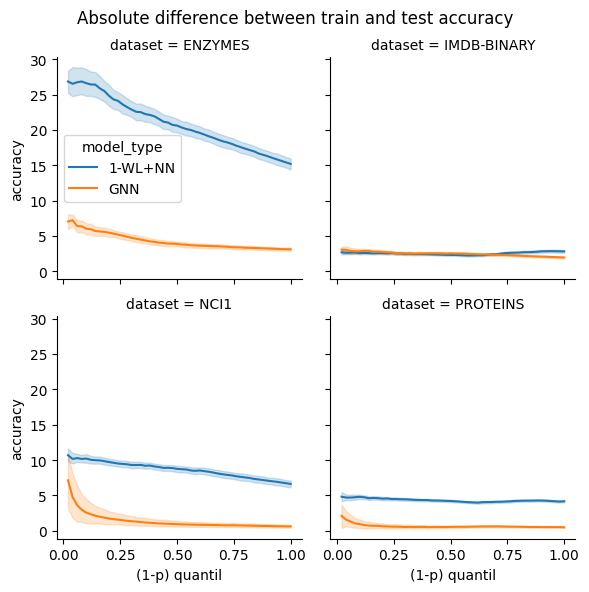

In [ ]:
df_abs_diff = df_diff[df_diff['acc_type'] == 'abs_diff']
g = sns.FacetGrid(df_abs_diff, col="dataset", hue="model_type", col_wrap=2, margin_titles=True, legend_out=False)
g.map(sns.lineplot, "quantil", "accuracy")
g.add_legend()
g.set_xlabels("(1-p) quantil")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Absolute difference between train and test accuracy")

Text(0.5, 0, '(1-p) quantil')

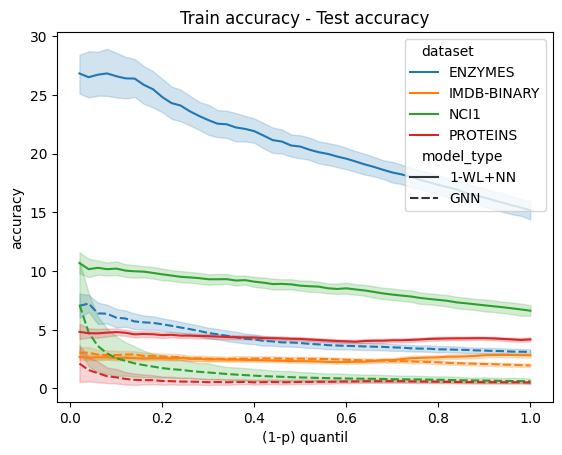

In [ ]:
abs_plot = sns.lineplot(data=df_abs_diff, x="quantil", y="accuracy", hue='dataset', style='model_type', err_style='band')
abs_plot.set_title("Train accuracy - Test accuracy")
abs_plot.set_xlabel("(1-p) quantil")

In [ ]:
data = []
for (grouped_col, grouped_df) in df_abs_diff.groupby(['dataset', 'quantil']):
    mean_wlnn_diff = grouped_df[grouped_df['model_type'] == '1-WL+NN']['accuracy'].mean()
    mean_gnn_diff = grouped_df[grouped_df['model_type'] == 'GNN']['accuracy'].mean()

    data.append({'dataset' : grouped_col[0], 'quantil' : grouped_col[1], 'abs_diff' : mean_wlnn_diff - mean_gnn_diff})

df_diff_mean = pd.DataFrame(data)
sns.lineplot(data=df_diff_mean, x="quantil", y="abs_diff", hue='dataset').set_title("Difference accross Model types:\n1-WL+NN - GNN")

NameError: name 'df_abs_diff' is not defined

In [ ]:
def calc_svm_boundary_contour(X, Y, train_index, test_index, n_points=5, **kwargs):
    clf = SVC(kernel='linear', **kwargs)
    clf.fit(X[train_index], Y[train_index])
    score = clf.score(X[test_index], Y[test_index])

    # Create a grid of points
    x_min = np.min(X[train_index].T, axis=1)
    x_max = np.max(X[train_index].T, axis=1)
    h = (x_max - x_min) / n_points

    arr_arange = [np.arange(x_min[i], x_max[i], h[i]) for i in range(len(x_min))]
    xx = np.meshgrid(*arr_arange)
    xx = np.hstack([dim.reshape(-1, 1) for dim in np.meshgrid(*arr_arange)])

    # Calculate the decision values for the grid points
    Z = clf.predict(xx)
        
    return xx, Z, score

In [ ]:
X = np.random.rand(100, 5)
Y = np.random.randint(0, 2, 100)

xx, Z, score = calc_svm_boundary_contour(X, Y, np.arange(0, 50), np.arange(50, 100))

In [ ]:
Z.shape

(3125,)

In [ ]:
def get_table(run_id, table_name):
    artifact = api.artifact(f'eric-bill/BachelorThesisExperiments/run-{run_id}-{table_name}:v0', type='run_table')
    artifact_dir = artifact.download()
    
    path = f'{artifact_dir}/{table_name}.table.json'
    with open(path) as file:
        json_dict = json.load(file)
        
    return pd.DataFrame(json_dict["data"], columns=json_dict["columns"])

aggregate_runs = runs_df[runs_df['Tags'] == 'aggregate_analysis']

df_agg = pd.DataFrame()
df_knn = pd.DataFrame()
for index, row in aggregate_runs.iterrows():

    # PCA and TSNE in same table
    for tabel_type in ['tsne', 'pca']:
        df_table = get_table(row['run_id'], tabel_type)
        df_table['dataset'] = row['dataset']
        df_table['model_type'] = row['model_type']
        df_table['table_type'] = tabel_type

        df_agg = pd.concat([df_agg, df_table], ignore_index=True)
    
    # KNN in seperate table
    df_knn_table = get_table(row['run_id'], 'knn')
    df_knn_table['dataset'] = row['dataset']
    df_knn_table['model_type'] = row['model_type']
    df_knn = pd.concat([df_knn, df_knn_table], ignore_index=True)

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


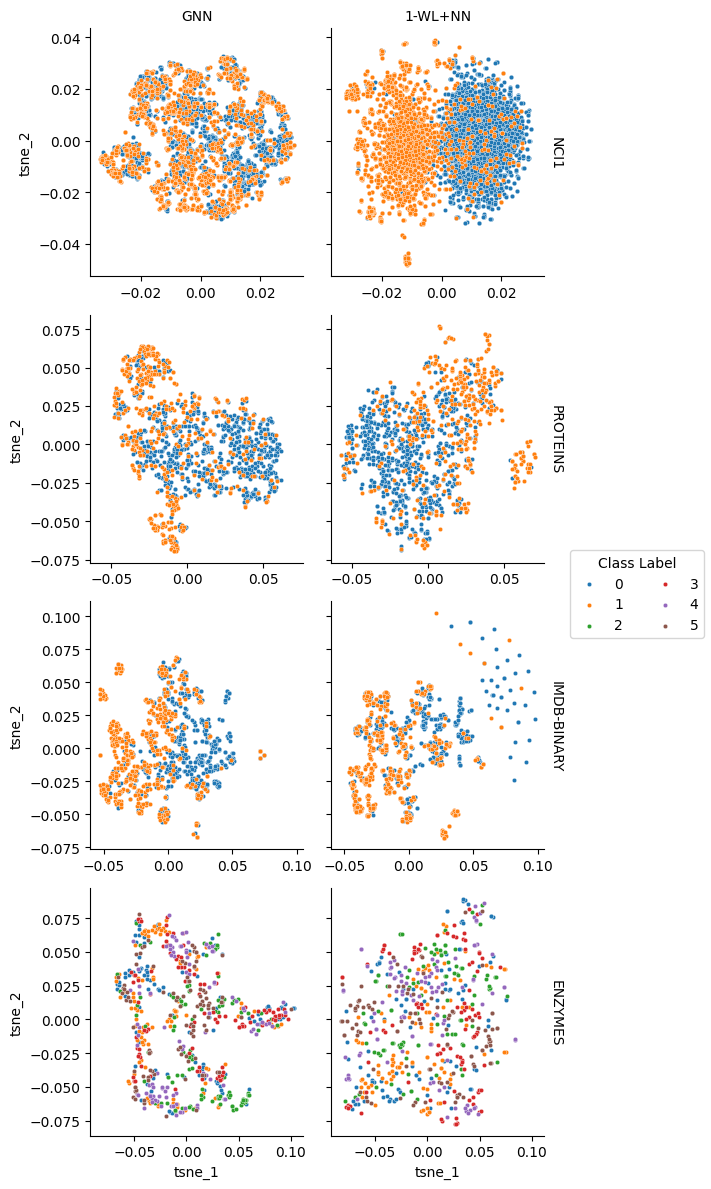

In [ ]:
method = 'tsne'

g = sns.FacetGrid(df_agg[df_agg['table_type'] == method], col='model_type', row='dataset', margin_titles=True, sharex='row', sharey='row', hue='class')
g.map_dataframe(sns.scatterplot, x='x', y='y', s=10)
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(title='Class Label', frameon=True, ncol=2)
g.set_axis_labels(f'{method}_1', f'{method}_2')

In [ ]:
# Process Data for SVM Analysis
df_svm = df_agg.copy()
df_svm['scatter'] = 1

score_dict = {}
for (g_col, g_df) in df_svm.groupby(['dataset', 'model_type', 'table_type']):
    data, score = calc_svm_boundary_contour(g_df, x_1='x', x_2='y', y='class', n_points=100)
    data['dataset'] = g_col[0]
    data['model_type'] = g_col[1]
    data['table_type'] = g_col[2]
    data['scatter'] = 0
    df_svm = pd.concat([df_svm, data], ignore_index=True)

    x_corr = g_df['x'].mean() + (g_df['x'].max() - g_df['x'].min()) * 0.10
    y_corr = g_df['y'].max() + (g_df['y'].max() - g_df['y'].min()) * 0.10
    score_dict[g_col] = (x_corr, y_corr, score)

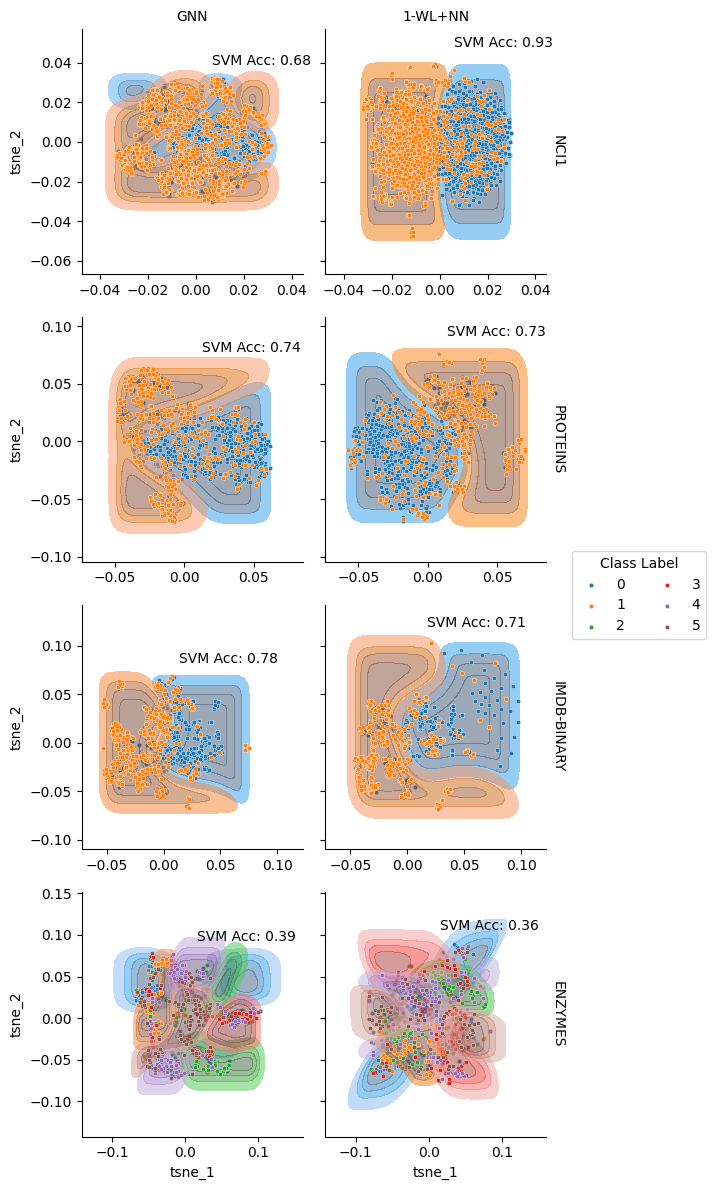

In [ ]:
def custom_plotter(data, x, y, **kwargs):
    sns.kdeplot(data=data[data['scatter'] == 0], x=x, y=y, levels=5, alpha=0.5, fill=True, thresh=0.1, **kwargs)
    sns.scatterplot(data=data[data['scatter'] == 1], x=x, y=y, s=10, **kwargs)

METHOD = 'tsne'

g = sns.FacetGrid(df_svm[df_svm['table_type'] == METHOD], col='model_type', row='dataset', hue='class', margin_titles=True, sharex='row', sharey='row')
g.map_dataframe(custom_plotter, x='x', y='y')
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(title='Class Label', frameon=True, ncol=2)
g.set_axis_labels(f'{METHOD}_1', f'{METHOD}_2')

for row in range(g.axes.shape[0]):
    for col in range(g.axes.shape[1]):
        x, y, score = score_dict[(g.row_names[row], g.col_names[col], METHOD)]
        g.axes[row, col].text(x, y, f"SVM Acc: {round(score, 2)}")

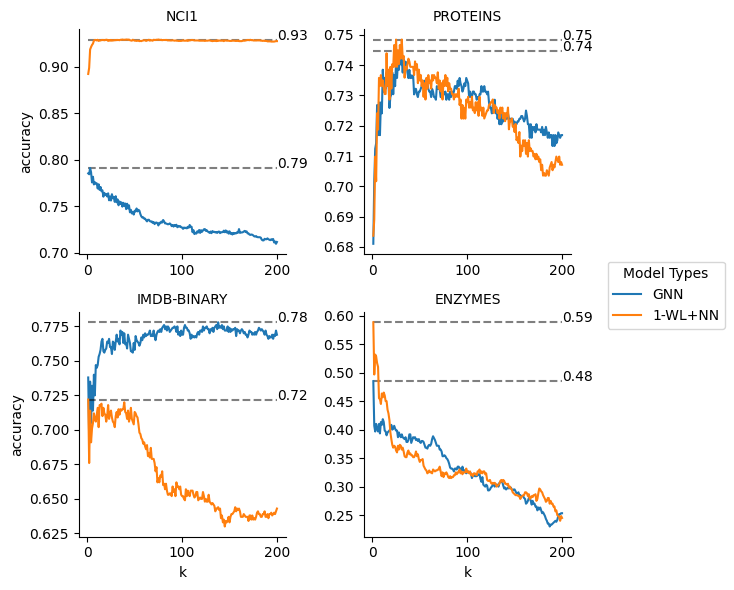

In [ ]:
def plot_knn(data, x, y, **kwargs):
    y_max = data[y].max()
    data_max = pd.DataFrame({'max': [y_max] * len(data), x: data[x]})
    
    sns.lineplot(data_max, x=x, y='max', color='black', alpha=0.5, linestyle='--')
    line = sns.lineplot(data=data, x=x, y=y, **kwargs)

    line.axes.text(data[x].max(), y_max, f"{round(y_max, 2)}")

g = sns.FacetGrid(df_knn, hue='model_type', col='dataset', col_wrap=2, margin_titles=True, sharex=False, sharey=False, legend_out=True)
g.map_dataframe(plot_knn, x='k', y='accuracy', legend='full')
g.add_legend(frameon=True)
g.set_titles(col_template="{col_name}", row_template="{row_name}")
sns.move_legend(g, "center right", bbox_to_anchor=(1.05, 0.5), title='Model Types')

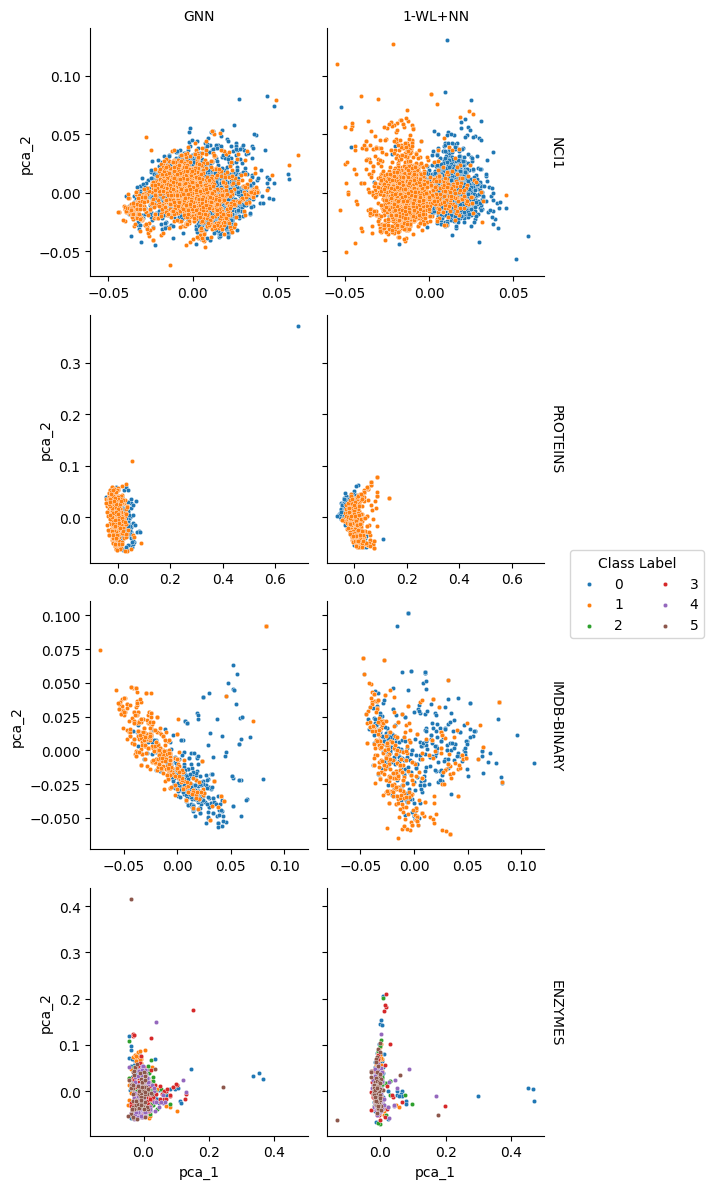

In [ ]:
method = 'pca'

g = sns.FacetGrid(df_agg[df_agg['table_type'] == method], col='model_type', row='dataset', margin_titles=True, sharex='row', sharey='row', hue='class')
g.map_dataframe(sns.scatterplot, x='x', y='y', s=10)
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(title='Class Label', frameon=True, ncol=2)
g.set_axis_labels(f'{method}_1', f'{method}_2')

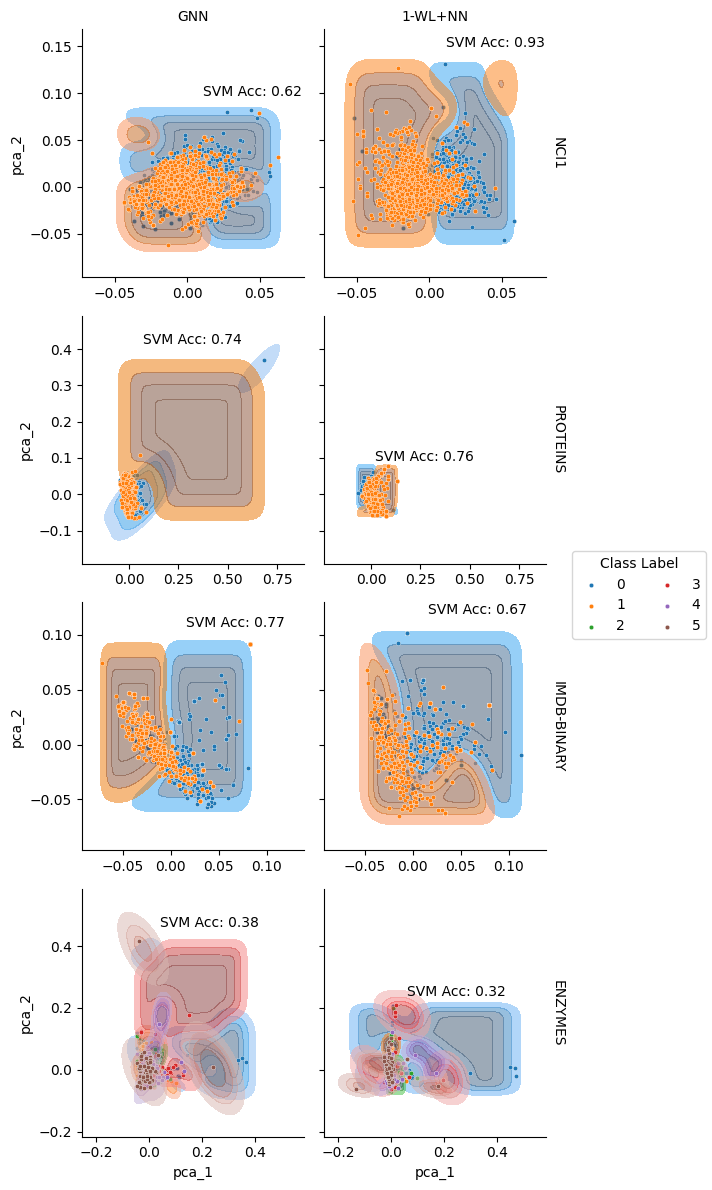

In [ ]:
def custom_plotter(data, x, y, **kwargs):
    sns.kdeplot(data=data[data['scatter'] == 0], x=x, y=y, levels=5, alpha=0.5, fill=True, thresh=0.1, **kwargs)
    sns.scatterplot(data=data[data['scatter'] == 1], x=x, y=y, s=10, **kwargs)

METHOD = 'pca'

g = sns.FacetGrid(df_svm[df_svm['table_type'] == METHOD], col='model_type', row='dataset', hue='class', margin_titles=True, sharex='row', sharey='row')
g.map_dataframe(custom_plotter, x='x', y='y')
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(title='Class Label', frameon=True, ncol=2)
g.set_axis_labels(f'{METHOD}_1', f'{METHOD}_2')

for row in range(g.axes.shape[0]):
    for col in range(g.axes.shape[1]):
        x, y, score = score_dict[(g.row_names[row], g.col_names[col], METHOD)]
        g.axes[row, col].text(x, y, f"SVM Acc: {round(score, 2)}")

In [ ]:
df_scores = []
for (key, val) in score_dict.items():
    df_scores.append({'dataset': key[0], 'model_type': key[1], 'table_type': key[2], 'score': int(round(val[2],2) * 100)})

df_scores = pd.DataFrame(df_scores)
df_scores = df_scores.pivot_table(index=['dataset', 'table_type'], columns='model_type', values='score')
df_scores.style.highlight_max(color = 'lightgreen', axis=1)

Weiteres Vorgehen:
- Pump up the number of runs
- IMDB model try out different k_wl values
- parameter für GNNs sweep verfeinern, da bei den GNNs mehr performance sein müsste (siehe andere Paper)
- vlt MUTAG und CIFAR10 noch als weitere datasets -> dann hätte man 2 aus jeder Kategorie der Taxonomie
-

Fragen:
- BA Aufbau, in Orndung?
- Proof reading of the proof?:)

In [ ]:
model = torch.load('saved_models/1WL+NN:Embedding-Sum: 14.06.2023 09:16:37.pt')

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

X, Y = make_blobs(5000, 32, centers=2, random_state=42)

# Getting linear decision boundary.
clf = SVC(kernel='linear')
clf.fit(X, Y)

In [ ]:
# Generating random points in the feature space.
x_min = X.min(axis=0)
x_max = X.max(axis=0)
x_rand = np.random.rand(10000, X.shape[1]) * (x_max - x_min) + x_min
y_rand = clf.predict(x_rand)

<Axes: xlabel='x', ylabel='y'>

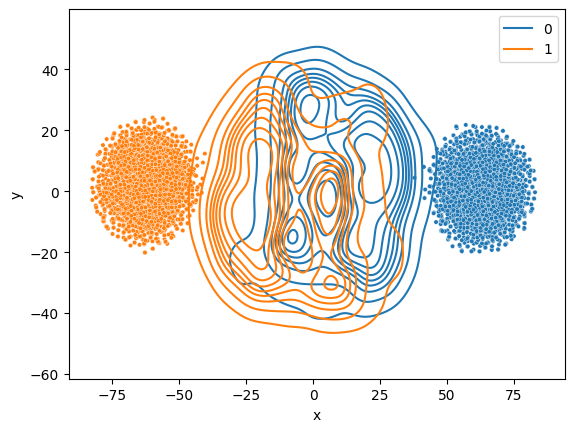

In [ ]:
# TSNE learning combined with hyperplane points.
x_tsne = TSNE(n_components=2, random_state=42).fit(np.concatenate((X, x_rand), axis=0))

# Seperating the hyperplane points from the original points.
x_tsne_rand = x_tsne[X.shape[0]:]
x_tsne = x_tsne[:X.shape[0]]

df_data = pd.DataFrame(x_tsne, columns=['x', 'y'])
sns.scatterplot(data=df_data, x='x', y='y', hue=Y, s=10)

df_plane = pd.DataFrame(x_tsne_rand, columns=['x', 'y'])
sns.kdeplot(data=df_plane, x='x', y='y', hue=y_rand)

<Axes: xlabel='x', ylabel='y'>

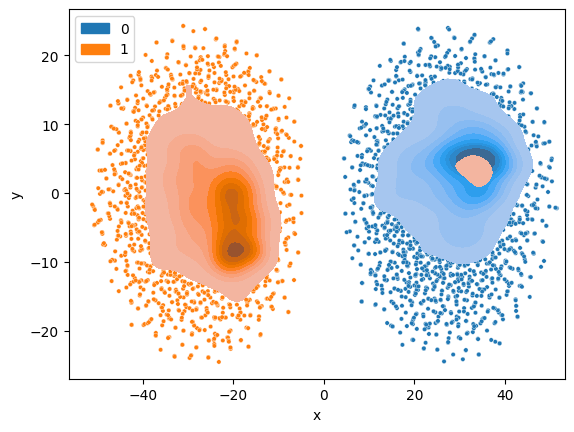

In [ ]:
# TSNE learning combined with hyperplane points.
x_tsne = TSNE(n_components=2, random_state=42).fit(X)

df_data = pd.DataFrame(x_tsne, columns=['x', 'y'])
sns.scatterplot(data=df_data, x='x', y='y', hue=Y, s=10)

# Transforming the hyperplane points to 2D.
x_tsne_rand = x_tsne.transform(x_rand)

df_plane = pd.DataFrame(x_tsne_rand, columns=['x', 'y'])
sns.kdeplot(data=df_plane, x='x', y='y', hue=y_rand, fill=False)

In [ ]:
# Generating random points on the hyperplane.

# Generating random points on the hyperplane.
x_min = X[:, :-1].min(axis=0) # 1. We determine the min and max values of each feature.
x_max = X[:, :-1].max(axis=0)
x_rand = np.random.rand(5000, X.shape[1] - 1) * (x_max - x_min) + x_min # 2. We generate random points in the range of each feature.
x_last_dim = - (x_rand @ clf.coef_[0, :-1] + clf.intercept_) / clf.coef_[0, -1] # 3. We calculate the last dimension of the hyperplane.
x_plane = np.hstack((x_rand, x_last_dim.reshape(-1, 1))) # 4. We combine the random points with the last dimension.

<Axes: xlabel='x', ylabel='y'>

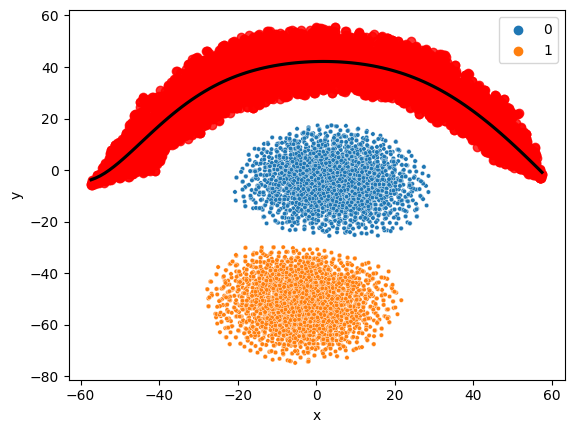

In [ ]:
# TSNE learning combined with hyperplane points.
x_tsne = TSNE(n_components=2, random_state=42).fit(np.concatenate((X, x_plane), axis=0))

# Seperating the hyperplane points from the original points.
x_plane_tsne = x_tsne[X.shape[0]:]
x_tsne = x_tsne[:X.shape[0]]

df_data = pd.DataFrame(x_tsne, columns=['x', 'y'])
sns.scatterplot(data=df_data, x='x', y='y', hue=Y, s=10)

df_plane = pd.DataFrame(x_plane_tsne, columns=['x', 'y'])
sns.regplot(data=df_plane, x='x', y='y', order=7, scatter=True, color='red', line_kws={'color': 'black'})

<Axes: xlabel='x', ylabel='y'>

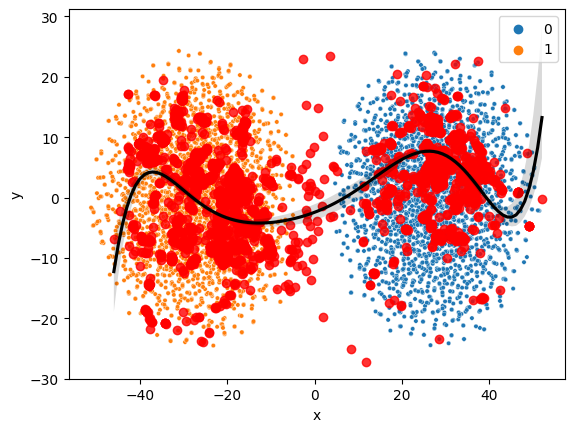

In [ ]:
# TSNE learning combined with hyperplane points.
x_tsne = TSNE(n_components=2, random_state=42).fit(X)

df_data = pd.DataFrame(x_tsne, columns=['x', 'y'])
sns.scatterplot(data=df_data, x='x', y='y', hue=Y, s=10)

# Transforming the hyperplane points to 2D.
x_plane_tsne = x_tsne.transform(x_plane)

df_plane = pd.DataFrame(x_plane_tsne, columns=['x', 'y'])
sns.regplot(data=df_plane, x='x', y='y', order=7, scatter=True, color='red', line_kws={'color': 'black'})

Text(74.08779850355347, 48.858303808954815, 'SVM Acc: 0.87')

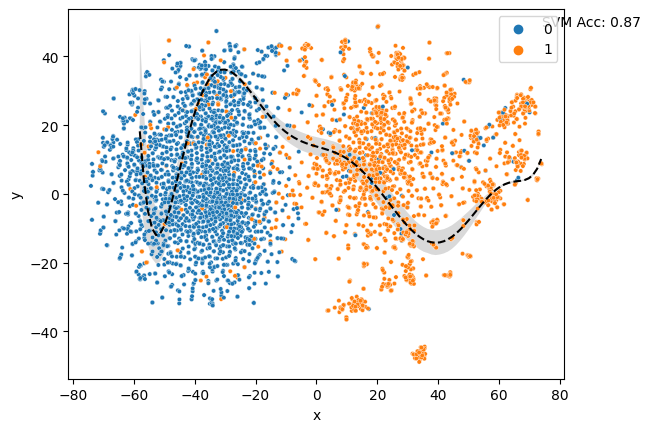

In [ ]:
from openTSNE import TSNE

# Get aggregate data. X is the data, Y is the labels.
agg_data = model.data_aggregate
X = agg_data[:, :-1].numpy()
Y = agg_data[:, -1].numpy().astype(int)
train_index, test_index = model.train_index, model.test_index

# Tranform the data to two dimensions and scatter plot it
clf = SVC(kernel='linear')
clf.fit(X[train_index], Y[train_index])
score = clf.score(X[test_index], Y[test_index])

# Generating NUM_POINTS random points that lie on the hyperplane, and missing the last dimension.
x_min = X[train_index].min(axis=0)[:-1]
x_max = X[train_index].max(axis=0)[:-1]
x_rand = np.random.rand(num_points, X.shape[1] - 1) * (x_max - x_min) + x_min

# Calculate the last dimension, such that the points lie on the hyperplane and concatenate it to the data.
x_last = -((clf.coef_[:, :-1] @ x_rand.T).T + clf.intercept_) / clf.coef_[:, -1]
x_plane = np.c_[x_rand, x_last]

# Reduce dimensionality of the data and the hyperplane simultaneously.
tsne = TSNE(
    perplexity=30,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=False,
)

x_tsne = tsne.fit(X)
x_plane_tsne = x_tsne.transform(x_plane)

# Find the polynomial degree that best fits the reduced data of the hyperplane.
min_resid = np.inf
min_deg = None
for deg in range(1, 10):
    _, res, _, _, _ = np.polyfit(x_plane_tsne[:,0], x_plane_tsne[:,1], deg, full=True)
    if res < min_resid:
        min_deg = deg

# Calclulate the polynomial coefficients and plot the hyperplane.
df_plane = pd.DataFrame(x_plane_tsne, columns=['x', 'y'])
sns.regplot(df_plane, x='x', y='y', order=min_deg, scatter=True,
            color='black', line_kws={'linestyle': '--', 'linewidth': 1.5})

# Plot the aggregate data.
df_data = pd.DataFrame(x_tsne, columns=['x', 'y'])
plot = sns.scatterplot(data=df_data, x='x', y='y', hue=Y, alpha=1.0, s=10)
plot.axes.text(x_tsne[:, 0].max(), x_tsne[:, 1].max(), f"SVM Acc: {round(score, 2)}")

Text(74.08779850355347, 48.858303808954815, 'SVM Acc: 0.87')

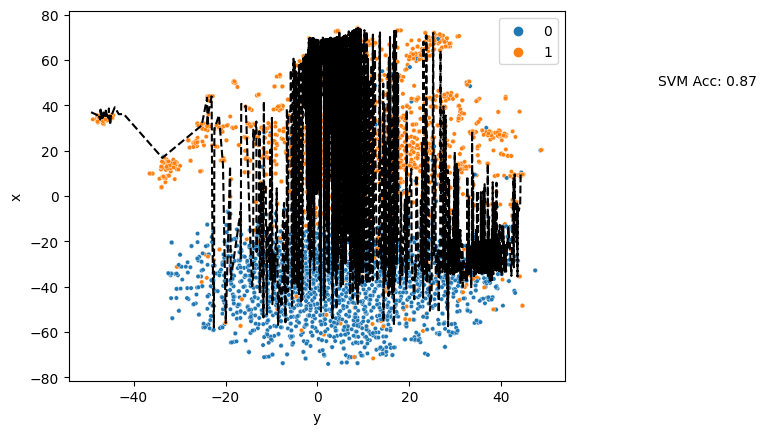

In [ ]:
# Calclulate the polynomial coefficients and plot the hyperplane.
df_plane = pd.DataFrame(x_plane_tsne, columns=['x', 'y'])
# sns.regplot(df_plane, x='y', y='x', order=min_deg, scatter=True,
#             color='black', line_kws={'linestyle': '--', 'linewidth': 1.5})
sns.lineplot(df_plane, x='y', y='x', color='black', linestyle='--', linewidth=1.5)

# Plot the aggregate data.
df_data = pd.DataFrame(x_tsne, columns=['x', 'y'])
plot = sns.scatterplot(data=df_data, x='y', y='x', hue=Y, alpha=1.0, s=10)
plot.axes.text(x_tsne[:, 0].max(), x_tsne[:, 1].max(), f"SVM Acc: {round(score, 2)}")

Text(28.018438, 26.819614, 'SVM Acc: 0.87')

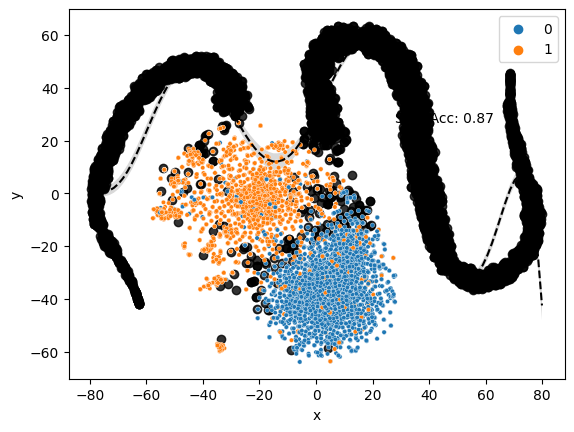

In [ ]:
df_plane = pd.DataFrame(tsne_plane, columns=['x', 'y'])
sns.regplot(df_plane, x='x', y='y', order=min_deg, scatter=True,
            color='black', line_kws={'linestyle': '--', 'linewidth': 1.5})

# Plot the aggregate data.
df_data = pd.DataFrame(tsne_data, columns=['x', 'y'])
plot = sns.scatterplot(data=df_data, x='x', y='y', hue=Y, alpha=1.0, s=10)
plot.axes.text(tsne_data[:, 0].max(), tsne_data[:, 1].max(), f"SVM Acc: {round(score, 2)}")

In [4]:
model = torch.load('saved_models/GIN:Max: 15.06.2023 10:09:01.pt')

In [5]:
dataset = model.dataset
train_index, test_index = model.train_index, model.test_index
agg_data = model.data_aggregate
proccesed_data = model.gnn(dataset.x, dataset.edge_index)

In [6]:
from utils import Wrapper_WL_TUDataset

wl_dataset = Wrapper_WL_TUDataset(dataset, k_wl=1, wl_convergence=False)


In [ ]:
clusters = []
y = []
for c in range(21249):
    indices = torch.argwhere(wl_dataset.data.x == c).squeeze()

    if indices.nelement() == 0:
        continue

    matching_tensors = proccesed_data[indices].reshape(-1, 128)
    clusters.append(matching_tensors)
    y += [c] * len(matching_tensors)

/opt/homebrew/Caskroom/miniconda/base/envs/pyg-m1/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [ ]:
clusters = torch.cat(clusters, dim=0)
clusters.detach_()
clusters.shape

torch.Size([43470, 128])

<Axes: xlabel='x', ylabel='y'>

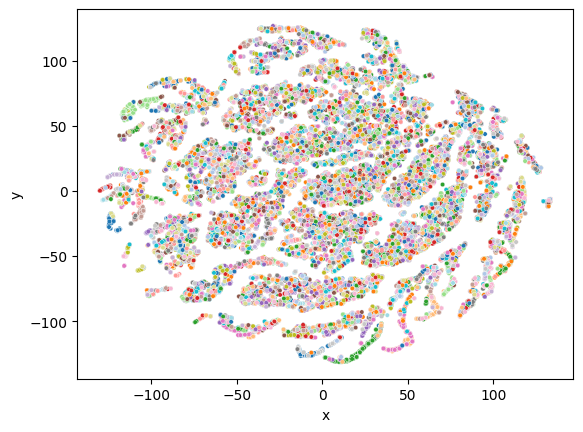

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, metric='euclidean', n_jobs=8, random_state=42, verbose=False).fit_transform(clusters)

df = pd.DataFrame(tsne, columns=['x', 'y'])
sns.scatterplot(data=df, x='x', y='y', hue=y, alpha=1.0, s=10, palette='tab20', legend=False)

In [14]:
from sklearn import metrics

all_metrics = ['rand_score', 'adjusted_rand_score', 'normalized_mutual_info_score', 'adjusted_mutual_info_score',
               'homogeneity_score', 'completeness_score', 'v_measure_score', 'fowlkes_mallows_score']
def evaluate(y_pred, y_true):
    rs = metrics.rand_score(y_true, y_pred)
    ars = metrics.adjusted_rand_score(y_true, y_pred)
    nmi = metrics.normalized_mutual_info_score(y_true, y_pred)
    ami = metrics.adjusted_mutual_info_score(y_true, y_pred)
    hom = metrics.homogeneity_score(y_true, y_pred)
    com = metrics.completeness_score(y_true, y_pred)
    vms = metrics.v_measure_score(y_true, y_pred)
    fws = metrics.fowlkes_mallows_score(y_true, y_pred)


    return {'rand_score': rs, 'adjusted_rand_score': ars, 'normalized_mutual_info_score': nmi,
            'adjusted_mutual_info_score': ami, 'homogeneity_score': hom, 'completeness_score': com,
            'v_measure_score': vms, 'fowlkes_mallows_score': fws}

In [186]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS, Birch, BisectingKMeans

data = []
for (index_name, index) in [('train', train_index), ('test', test_index)]:
        with torch.no_grad():
                x_gnn = model.gnn(dataset[index].x, dataset[index].edge_index)
        x_wl = wl_dataset[index].x

        num_cluster = len(torch.unique(x_wl))

        kmeans = KMeans(n_clusters=num_cluster, random_state=42, init='k-means++', n_init='auto').fit(x_gnn)
        data.append(evaluate(kmeans.labels_, x_wl) | {'name': 'kmeans', 'index': index_name})

        aggC_ward = AgglomerativeClustering(n_clusters=num_cluster, linkage='ward').fit(x_gnn)
        data.append(evaluate(aggC_ward.labels_, x_wl) | {'name': 'aggC_ward', 'index': index_name})

        aggC_avg = AgglomerativeClustering(n_clusters=num_cluster, linkage='average').fit(x_gnn)
        data.append(evaluate(aggC_avg.labels_, x_wl) | {'name': 'aggC_avg', 'index': index_name})

        dbscan = DBSCAN(eps=0.5, min_samples=5).fit(x_gnn)
        data.append(evaluate(dbscan.labels_, x_wl) | {'name': 'dbscan', 'index': index_name})

        optics = OPTICS(min_samples=5).fit(x_gnn)
        data.append(evaluate(optics.labels_, x_wl) | {'name': 'optics', 'index': index_name})

        birch = Birch(n_clusters=num_cluster).fit(x_gnn)
        data.append(evaluate(birch.labels_, x_wl) | {'name': 'birch', 'index': index_name})

        bisectingKmeans = BisectingKMeans(n_clusters=num_cluster).fit(x_gnn)
        data.append(evaluate(bisectingKmeans.labels_, x_wl) | {'name': 'bisectingKmeans', 'index': index_name})

df_data = pd.DataFrame(data)

: 

: 

In [185]:
df_data.pivot_table(index=['name'], columns=['index'] + all_metrics, values=all_metrics)

KeyError: 'index'

In [183]:
df_data = pd.DataFrame(data)
df_data.style.highlight_max(color='lightgreen', axis=0, subset=['rand_score', 'adjusted_rand_score', 'normalized_mutual_info_score', 'adjusted_mutual_info_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'fowlkes_mallows_score'])

,rand_score,adjusted_rand_score,normalized_mutual_info_score,adjusted_mutual_info_score,homogeneity_score,completeness_score,v_measure_score,fowlkes_mallows_score,name
0,0.999394,0.419173,0.963724,0.596497,0.969366,0.958148,0.963724,0.432831,kmeans
1,0.999423,0.430276,0.964563,0.599914,0.971402,0.957820,0.964563,0.449171,aggC_ward
2,0.999376,0.489928,0.965213,0.630197,0.967129,0.963305,0.965213,0.491229,aggC_avg
3,0.173840,0.000272,0.098062,0.026001,0.051562,0.998831,0.098062,0.028052,dbscan
4,0.643698,0.000652,0.507579,0.083588,0.347949,0.937834,0.507579,0.022859,optics
5,0.978139,0.043657,0.696769,0.248775,0.541736,0.976109,0.696769,0.134939,birch
6,0.999407,0.397529,0.961135,0.555755,0.968925,0.953470,0.961135,0.420232,bisectingKmeans


In [7]:
with torch.no_grad():
    x_train = []
    y_train = []

    for idx in train_index:
        x_gnn = model.gnn(dataset[idx].x, dataset[idx].edge_index)
        x_wl = wl_dataset[idx].x

        x_train.append(x_gnn)
        y_train.append(x_wl)

    x_train = torch.cat(x_train, dim=0)
    y_train = torch.cat(y_train, dim=0)

    x_test = []
    y_test = []

    for idx in test_index:
        x_gnn = model.gnn(dataset[idx].x, dataset[idx].edge_index)
        x_wl = wl_dataset[idx].x

        x_test.append(x_gnn)
        y_test.append(x_wl)

    x_test = torch.cat(x_test, dim=0)
    y_test = torch.cat(y_test, dim=0)

In [19]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS, Birch, BisectingKMeans
data = []
num_cluster = len(torch.unique(y_train))

kmeans = KMeans(n_clusters=num_cluster, random_state=42, init='k-means++', n_init='auto').fit(x_train)
data.append(evaluate(kmeans.labels_, y_train) | {'name': 'kmeans'})

aggC_ward = AgglomerativeClustering(n_clusters=num_cluster, linkage='ward').fit(x_train)
data.append(evaluate(aggC_ward.labels_, y_train) | {'name': 'aggC_ward'})

aggC_avg = AgglomerativeClustering(n_clusters=num_cluster, linkage='average').fit(x_train)
data.append(evaluate(aggC_avg.labels_, y_train) | {'name': 'aggC_avg'})

dbscan = DBSCAN(eps=0.5, min_samples=5).fit(x_train)
data.append(evaluate(dbscan.labels_, y_train) | {'name': 'dbscan'})

optics = OPTICS(min_samples=5).fit(x_train)
data.append(evaluate(optics.labels_, y_train) | {'name': 'optics'})

birch = Birch(n_clusters=num_cluster).fit(x_train)
data.append(evaluate(birch.labels_, y_train) | {'name': 'birch'})

bisectingKmeans = BisectingKMeans(n_clusters=num_cluster).fit(x_train)
data.append(evaluate(bisectingKmeans.labels_, y_train) | {'name': 'bisectingKmeans'})

: 

: 

In [18]:
pd.DataFrame(data)

,rand_score,adjusted_rand_score,normalized_mutual_info_score,adjusted_mutual_info_score,homogeneity_score,completeness_score,v_measure_score,fowlkes_mallows_score,name
0,0.966394,0.297932,0.687398,0.613401,0.780458,0.614167,0.687398,0.367233,kmeans
1,0.966792,0.292508,0.710801,0.640931,0.812982,0.631438,0.710801,0.369268,aggC_ward
2,0.948761,0.340135,0.653657,0.592979,0.655570,0.651755,0.653657,0.367724,aggC_avg
3,0.209294,0.014530,0.146240,0.130254,0.080907,0.759746,0.146240,0.208999,dbscan
4,0.635521,-0.000065,0.423289,0.258958,0.374406,0.486854,0.423289,0.114880,optics
5,0.955879,0.296869,0.617139,0.546602,0.641659,0.594424,0.617139,0.322979,birch
6,0.963721,0.243572,0.638928,0.553630,0.725273,0.570954,0.638928,0.303362,bisectingKmeans


In [14]:
def inverse_permutation(perm):
    inv = torch.empty_like(perm)
    inv[perm] = torch.arange(perm.size(0), device=perm.device)
    return inv

x = torch_geometric.datasets.TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
print(x[0].x.shape)

x, perm = x.shuffle(return_perm=True)
print(x[0].x.shape)

inv = inverse_permutation(perm)
x = x[inv]
print(x[0].x.shape)


torch.Size([37, 3])
torch.Size([48, 3])
torch.Size([37, 3])
